In [173]:
import pandas as pd
import matplotlib.pyplot as plt

In [174]:
# Importing the dataset
df = pd.read_csv("megaGymDataset.csv")
df = df.rename(columns={'Unnamed: 0': 'index'})
df

,index,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,NaN
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,8.1,Average
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,Strength,Triceps,E-Z Curl Bar,Beginner,8.1,Average
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN


In [175]:
#Cheking if there is any NULL or missing values
df.isna().sum()

index            0
Title            0
Desc          1550
Type             0
BodyPart         0
Equipment        0
Level            0
Rating        1887
RatingDesc    2056
dtype: int64

In [176]:
# DATA ANALYSIS

# Some exercises has the same title - Should remove duplicates?
df = df.drop_duplicates('Title', keep='last')
df['Title'].value_counts()

Partner plank band row               1
Seesaw lunge                         1
Dumbbell split squat                 1
Dumbbell deadlift                    1
Single-arm stiff-legged deadlift     1
                                    ..
Tiger-bend push-up                   1
Plyo push-up                         1
Close-grip hands-elevated push-up    1
Suspended push-up                    1
30 Arms EZ-Bar Skullcrusher          1
Name: Title, Length: 2909, dtype: int64

<Axes: >

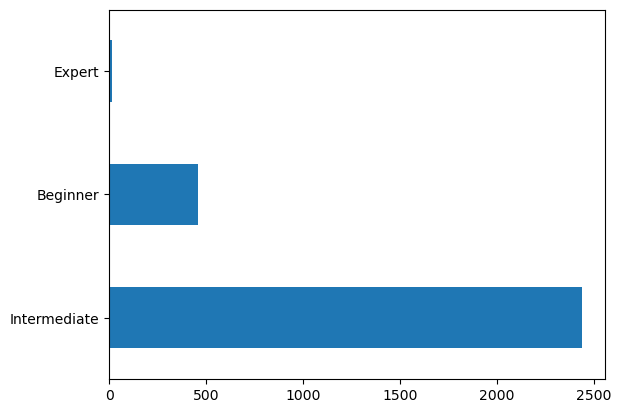

In [177]:
# Sorted bv level
df['Level'].value_counts().plot.barh()

<Axes: >

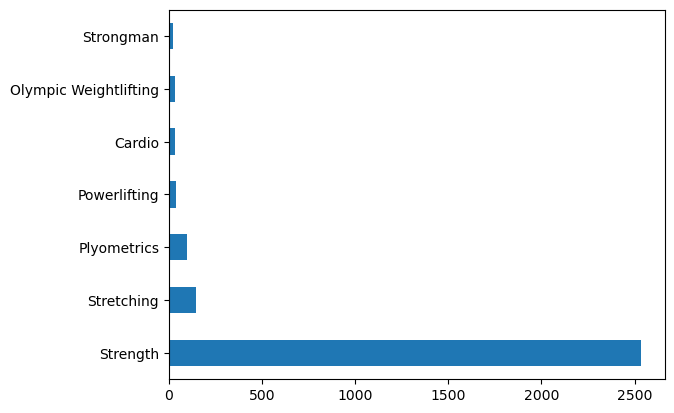

In [178]:
# sorted by type
df['Type'].value_counts().plot.barh()

<Axes: >

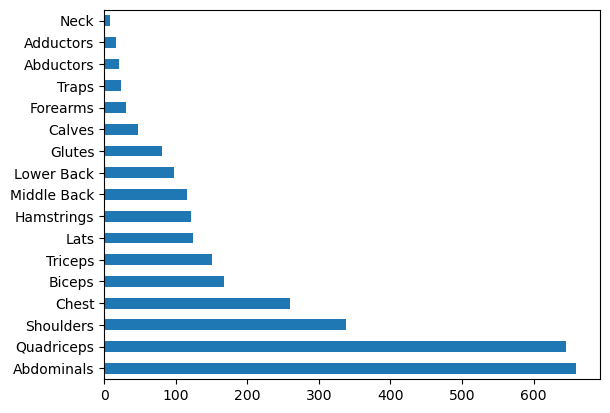

In [179]:
# sorted by bodypart
df['BodyPart'].value_counts().plot.barh()

In [180]:
# top rated exercises
ratingSorted= df.sort_values(by='Rating',ascending=False)
ratingSorted =ratingSorted.head(10)
ratingSorted

,index,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
1195,1195,Rickshaw Carry,NaN,Strongman,Forearms,Other,Beginner,9.6,Average
2065,2065,Single-Leg Press,The single-leg leg press is an exercise target...,Strength,Quadriceps,Machine,Intermediate,9.6,Average
1695,1695,T-Bar Row with Handle,NaN,Strength,Middle Back,Other,Intermediate,9.5,Average
731,731,Incline Hammer Curls,NaN,Strength,Biceps,Dumbbell,Beginner,9.5,Average
1179,1179,Palms-down wrist curl over bench,The palms-down wrist curl over bench is an exe...,Strength,Forearms,Barbell,Intermediate,9.5,Average
1577,1577,Atlas Stones,NaN,Strongman,Lower Back,Other,Intermediate,9.5,Average
1451,1451,Weighted pull-up,The weighted pull-up is a more advanced variat...,Strength,Lats,Other,Intermediate,9.5,Average
2525,2525,Dumbbell front raise to lateral raise,The dumbbell front raise to lateral raise is a...,Strength,Shoulders,Dumbbell,Intermediate,9.5,Average
1798,1798,Clean from Blocks,NaN,Olympic Weightlifting,Quadriceps,Barbell,Beginner,9.5,Average
88,88,Landmine twist,The landmine twist is a rotational abdominal m...,Strength,Abdominals,Other,Intermediate,9.5,Average


In [181]:
# Prints the row of the given Title to find the index
print(df[df["Title"] == "Bench press"])
df.loc[df['Title'] == "Bench press", 'Rating'] = 10
print(df[df["Title"] == "Bench press"])

     index        Title                                               Desc  \
942    942  Bench press  The bench press is a popular barbell exercise ...   

         Type BodyPart Equipment         Level  Rating RatingDesc  
942  Strength    Chest   Barbell  Intermediate     NaN        NaN  
     index        Title                                               Desc  \
942    942  Bench press  The bench press is a popular barbell exercise ...   

         Type BodyPart Equipment         Level  Rating RatingDesc  
942  Strength    Chest   Barbell  Intermediate    10.0        NaN  


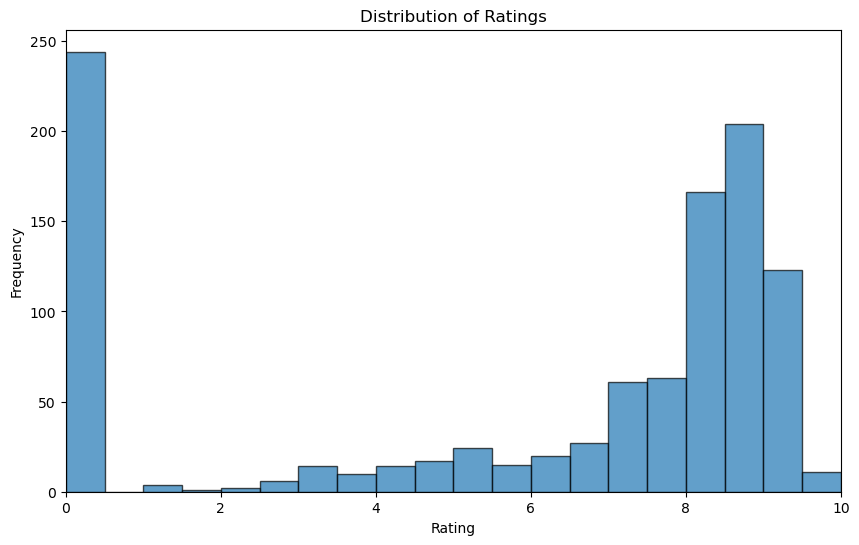

In [182]:
df_sorted = df.sort_values(by="Rating")
# Create a histogram of the "Ratings" column
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Create a histogram of the "Ratings" column
plt.hist(df_sorted["Rating"], bins=20, edgecolor="k", alpha=0.7)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(False)
plt.xlim(df_sorted["Rating"].min(), df_sorted["Rating"].max())
plt.ylim(0, plt.gca().get_ylim()[1])
plt.show()

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from copy import deepcopy
import numpy as np

# Datasett for trening. Gjør om strenger til kategorier (int)
x = deepcopy(df)
x = x.drop(["Title"], axis = 1)
x = x.drop(["Desc"], axis = 1)
x = x.drop(["RatingDesc"], axis = 1)
x['Level'] = pd.factorize(x['Level'])[0]
x['Type'] = pd.factorize(x['Type'])[0]
x['BodyPart'] = pd.factorize(x['BodyPart'])[0]
x['Equipment'] = pd.factorize(x['Equipment'])[0]
x = x[x['Rating'].notna()]
x = x[df["Rating"] != 0]
# Verdier som skal predikeres, brukes for trening og testing
y = x["Rating"]
#y = y.round(0)
#y = y.astype(int)
x = x.drop(["Rating"], axis = 1)
#y=y.replace(0,1)
#y=y.replace(0.0,1)
#y=y.replace(np.nan,1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

# Grid search for å finne beste params
from sklearn.model_selection import GridSearchCV
'''
param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17],
    'p': [1, 2]
}
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
params = grid_search.best_params_
'''
param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17],
    'p': [1, 2]
}
grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
params = grid_search.best_params_
print(params)

# Traiing
knn = KNeighborsRegressor(n_neighbors = params['n_neighbors'], p = params["p"])
knn.fit(X_train, y_train)


# Ny variabel X. Alle rader fra dataframe som ikke har rating
x = deepcopy(df)
# Ekskluderer øvelser med ratings
x = df[df['Rating'].isin([0, np.nan])]

# Gjør om strenger til kategorier (int) for prediction
x = x.drop(["Rating"], axis = 1)
x = x.drop(["Title"], axis = 1)
x = x.drop(["Desc"], axis = 1)
x = x.drop(["RatingDesc"], axis = 1)
x['Level'] = pd.factorize(x['Level'])[0]
x['Type'] = pd.factorize(x['Type'])[0]
x['BodyPart'] = pd.factorize(x['BodyPart'])[0]
x['Equipment'] = pd.factorize(x['Equipment'])[0]

# Antall nonvalues
print("Nonvalues rating før:",df["Rating"].isna().sum())

# Predikerer en rating for hver rad i dataframe som ikke har rating
for index, row in x.iterrows():
    rating = knn.predict([row])
    #print(row["index"], rating)
    df.loc[df['index'] == index, 'Rating'] = rating

print("Nonvalues rating etter",df["Rating"].isna().sum())

filtered_df = df[df["Rating"] == 0]
print(len(filtered_df))

/var/folders/mk/8n8zy8bx2wg6sc_jvckk3g2c0000gn/T/ipykernel_4842/3033576057.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[df["Rating"] != 0]
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thorsteinfougner/anac

{'n_neighbors': 3, 'p': 1}
Nonvalues rating før: 1883


/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featur

Nonvalues rating etter 0
0


/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/thorsteinfougner/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with featur

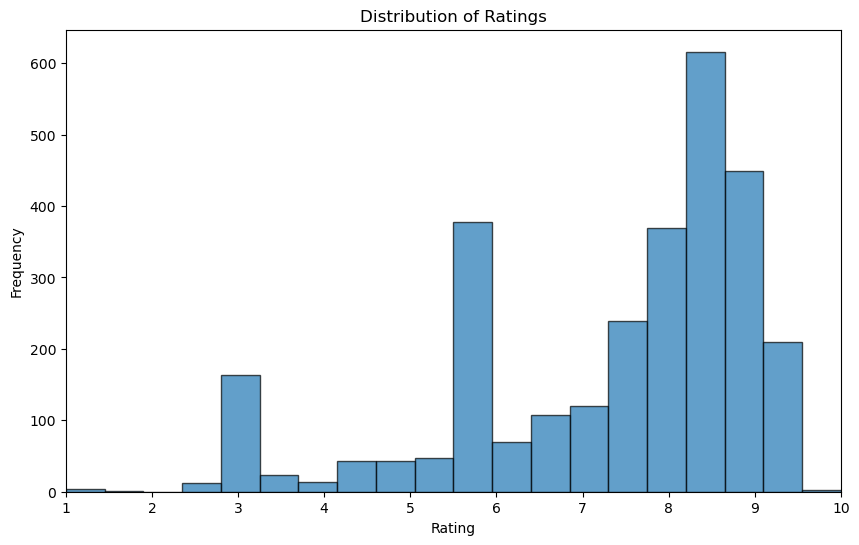

In [184]:
df_sorted = df.sort_values(by="Rating")
# Create a histogram of the "Ratings" column
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Create a histogram of the "Ratings" column
plt.hist(df_sorted["Rating"], bins=20, edgecolor="k", alpha=0.7)

plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(False)
plt.xlim(df_sorted["Rating"].min(), df_sorted["Rating"].max())
plt.ylim(0, plt.gca().get_ylim()[1])
plt.show()

In [185]:
# Removing columns with lots of nonvalues
#df = df.drop('Rating', axis=1)
df = df.drop('RatingDesc', axis=1)
# Removing all rows containing nonvalues in description
df = df[df['Desc'].notna()]
#df = df[df['Rating'].notna()]
# Removing ID column
df.pop(df.columns[0])



0          0
1          1
2          2
3          3
4          4
        ... 
2911    2911
2912    2912
2913    2913
2915    2915
2916    2916
Name: index, Length: 1359, dtype: int64

In [186]:
# Checking datatypes
df.dtypes

Title         object
Desc          object
Type          object
BodyPart      object
Equipment     object
Level         object
Rating       float64
dtype: object

In [187]:
# Merging columns for cosign similarity and dropping excess columns
df["Merged"] = df["Type"].astype(str) + '|' + \
  df["BodyPart"].astype(str) + '|' + df["Equipment"].astype(str) + '|' + \
  df["Level"]

df = df.drop('Type', axis=1)
df = df.drop('BodyPart', axis=1)
df = df.drop('Equipment', axis=1)
df = df.drop('Level', axis=1)

In [188]:
# The merged columns
df["Merged"]

0           Strength|Abdominals|Bands|Intermediate
1           Strength|Abdominals|Bands|Intermediate
2           Strength|Abdominals|Bands|Intermediate
3           Strength|Abdominals|Bands|Intermediate
4           Strength|Abdominals|Bands|Intermediate
                           ...                    
2911    Strength|Triceps|E-Z Curl Bar|Intermediate
2912    Strength|Triceps|E-Z Curl Bar|Intermediate
2913    Strength|Triceps|E-Z Curl Bar|Intermediate
2915    Strength|Triceps|E-Z Curl Bar|Intermediate
2916    Strength|Triceps|E-Z Curl Bar|Intermediate
Name: Merged, Length: 1359, dtype: object

In [189]:
# Converting values of the merged column into vectors

from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
count_matrix = count.fit_transform(df.loc[:,"Merged"])

liste = count_matrix.toarray()

In [190]:
# Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(count_matrix, count_matrix)

In [191]:
#sim_matrix

In [192]:
# Resetting the index to avoid indexing errors and NAN values in recommender
# This makes the previous indexes invalid
# "drop" avoids adding the old index as a column
df = df.reset_index(drop = False)

In [193]:
def recommender(data_frame, exercise_id, sim_matrix):
    sim_df = pd.DataFrame(sim_matrix[exercise_id],
                         columns=["Similarity"])
    exercise_titles = data_frame.loc[:, "Title"]
    exercise_rec = pd.concat([sim_df, exercise_titles], axis = 1)
    return exercise_rec

In [194]:
# Prints the row of the given Title to find the index
row = df[df["Title"] == "Bench press"]
index = row.index

In [195]:
# Exercises similar to bench press
df_by_cat = recommender(df, 1115, sim_matrix)

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [197]:
tfidf = TfidfVectorizer(stop_words="english")
overview_matrix = tfidf.fit_transform(df["Desc"])
overview_matrix.shape

(1359, 1918)

In [198]:
similarity_matrix = linear_kernel(overview_matrix, overview_matrix)
print(similarity_matrix[0:5,0:5])

[[1.         0.1544238  0.15958079 0.16654907 0.12296181]
 [0.1544238  1.         0.13114796 0.92719703 0.21069057]
 [0.15958079 0.13114796 1.         0.14144562 0.00427982]
 [0.16654907 0.92719703 0.14144562 1.         0.22723387]
 [0.12296181 0.21069057 0.00427982 0.22723387 1.        ]]


In [199]:
mapping = pd.Series(df.index, index = df["Desc"])
mapping

Desc
The partner plank band row is an abdominal exercise where two partners perform single-arm planks while pulling on the opposite ends of an exercise band. This technique can be done for time or reps in any ab-focused workout.                                                                                                                                                0
The banded crunch isometric hold is an exercise targeting the abdominal muscles, particularly the rectus abdominis or "six-pack" muscles. The band adds resistance and continuous tension to this popular exercise.                                                                                                                                                            1
The banded plank jack is a variation on the plank that involves moving the legs in and out for repetitions. Having a band around the thighs forces the lower body to work harder, particularly the hips and glutes. The plank jack is commonly performed as part 

In [200]:

def recommender_by_desc(exercise_input, df, similarity_matrix, mapping):
    exercise_index = mapping[exercise_input]
    if not isinstance(exercise_index, np.int64):
        exercise_index = exercise_index[0]
    similarity_score = list(enumerate(similarity_matrix[exercise_index]))
    score = [tup[1] for tup in similarity_score]
    exercise_indices = [i[0] for i in similarity_score]
    df2 = df["Title"].iloc[exercise_indices].to_frame()
    df2["Similarity"] = score
    return df2


In [201]:
df_by_desc = recommender_by_desc(df["Desc"][1115], df, similarity_matrix, mapping)

In [202]:
merged_df = df_by_cat.copy()
merged_df["Similarity"] = (df_by_cat["Similarity"] + df_by_desc["Similarity"]) / 2
merged_df = merged_df.sort_values(by=["Similarity"], ascending=False)
merged_df[0:10]

,Similarity,Title
1115,1.000000,Machine Shoulder (Military) Press
1128,0.690767,AM Barbell Shoulder Press
1129,0.690767,Standing barbell shoulder press
1110,0.631376,Standing Bradford press
1123,0.617503,TBS Barbell Military Press
1108,0.617503,Military press
1246,0.609998,Machine shoulder press
1114,0.606010,Lying rear delt fly
1125,0.604460,Barbell Front Raise - Gethin Variation
1117,0.604460,Barbell front raise
